In [52]:
# Importing necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding,  BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [41]:
# loading the dataset
data = pd.read_csv('/content/Amazon-Product-Review-Sentiment-Analysis-using-RNN-Dataset.csv')

# Printing shape of the dataset
print(data.shape)
# printing columns and rows information
print(data.info())

(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [42]:
# looking for NULL values
print("Null Values :\n", data.isnull().sum())

# dropping null values
data = data.dropna()

# again checking for NULL values
print("Null Values after dropping:\n", data.isnull().sum())

Null Values :
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [43]:
# count of unique values in Sentiment column
data["Sentiment"].value_counts()

,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


Text Cleaning


In [44]:
# downloading stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# downloading punkt sentence tokenizer models
nltk.download('punkt')

# Review text Cleaning
def clean_reviews(text):

    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)

    # converting text to lower case
    text = text.lower()

    # Tokenization of words
    text = word_tokenize(text)

    # Stop words removal
    text = [word for word in text if not word in stop_words]

    return text

# using the clean_reviews function on the dataset
data['Review'] = data['Review'].apply(clean_reviews)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenization & Text Encoding

In [45]:
tokenizer = Tokenizer()

# converting all the reviews to list to pass it as a parameter to fit_on_texts
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generating text sequences
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# setting maximum words we want in an example
max_words = 500

# Padding sequences
# - Before converting to a NumPy array, pad the sequences to ensure they all have the same length.
padded_sequences = pad_sequences(text_sequences, maxlen=max_words) # Use the same max_words value

text_sequences = np.array(padded_sequences)

# one hot encoding
data = pd.get_dummies(data, columns = ['Sentiment'])


# Generatin our X (input) to the model
# using pad_sequences and y (output)
X = pad_sequences(text_sequences, maxlen = max_words)
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4',
    'Sentiment_5']]
print(X.shape, y.shape)

# This code is modified by Susobhan Akhuli

(24999, 500) (24999, 5)


In [46]:
data.head()

,Review,Sentiment_1,Sentiment_2,Sentiment_3,Sentiment_4,Sentiment_5
0,"[fast, shipping, product, cheaply, made, broug...",True,False,False,False,False
1,"[case, takes, long, ship, even, worth, dont, buy]",True,False,False,False,False
2,"[good, droids, good, iphones, use, features, w...",True,False,False,False,False
3,"[cable, compatible, macbook, iphone, also, con...",True,False,False,False,False
4,"[case, nice, glow, light, im, disappointed, pr...",True,False,False,False,False


Split our dataset into training and testing datasets

In [47]:
# Train Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


Build the Model

In [55]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Input(shape=(max_words,)))
rnn.add(Embedding(len(tokenizer.word_index)+1,
                        max_words,
                        input_length=max_words))

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(Dense(5, activation='softmax'))

# printing model summary
print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 500, 500)       │    19,819,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 500, 128)       │        80,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,912,689 (75.96 MB)

 Trainable params: 19,912,689 (75.96 MB)

 Non-trainable params: 0 (0.00 B)

None


In [49]:
# Compiling model
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=2,
                        verbose=1,
                          validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score : ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.2733 - loss: 2.0616 - val_accuracy: 0.4238 - val_loss: 1.2902
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.5345 - loss: 1.1174 - val_accuracy: 0.4622 - val_loss: 1.2457
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.4639 - loss: 1.2476
Simple_RNN Score :  [1.2456884384155273, 0.46219998598098755]


Use LATM to improve the model performance

In [53]:
model = Sequential(name="LSTM_Model")
model.add(Input(shape=(max_words,)))
model.add(Embedding(len(tokenizer.word_index)+1,
                    max_words,
                    input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# printing model summary
print(model.summary())

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 500, 500)       │    19,819,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       390,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,217,905 (77.13 MB)

 Trainable params: 20,217,905 (77.13 MB)

 Non-trainable params: 0 (0.00 B)

None


In [56]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the GRU model
history = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=3,
                         verbose=1,
                       validation_data=(X_test, y_test))

# Printing model score on test data
print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 929s 3s/step - accuracy: 0.3068 - loss: 1.4992 - val_accuracy: 0.4640 - val_loss: 1.2301
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 959s 3s/step - accuracy: 0.5310 - loss: 1.1050 - val_accuracy: 0.4592 - val_loss: 1.2395
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 971s 3s/step - accuracy: 0.6361 - loss: 0.9007 - val_accuracy: 0.4582 - val_loss: 1.3825
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 458ms/step - accuracy: 0.4535 - loss: 1.3836
LSTM model Score--->  [1.3825104236602783, 0.45820000767707825]


Text(0, 0.5, 'Accuracy')

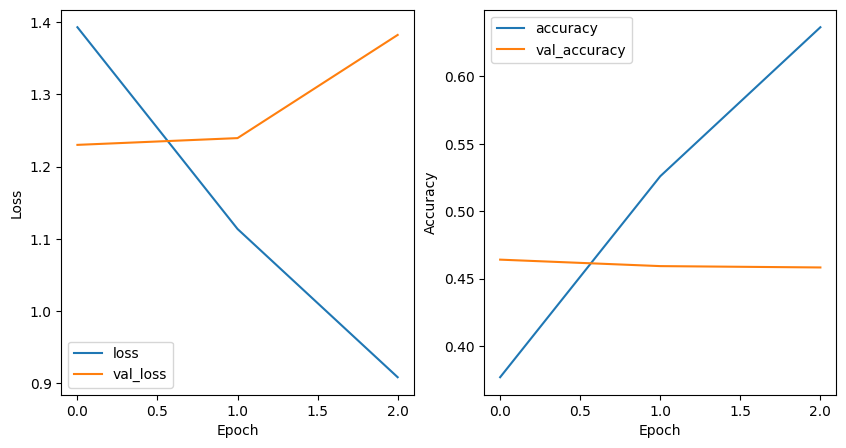

In [57]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
         metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

157/157 ━━━━━━━━━━━━━━━━━━━━ 92s 581ms/step


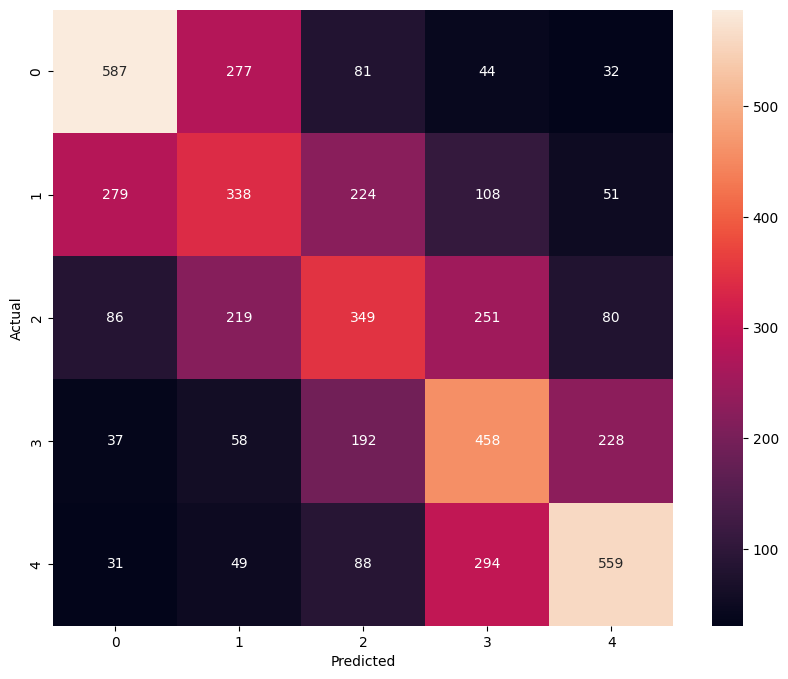

In [58]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [59]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.57      0.58      1021
           1       0.36      0.34      0.35      1000
           2       0.37      0.35      0.36       985
           3       0.40      0.47      0.43       973
           4       0.59      0.55      0.57      1021

    accuracy                           0.46      5000
   macro avg       0.46      0.46      0.46      5000
weighted avg       0.46      0.46      0.46      5000



Testing the trained model


In [60]:
def predict_review_rating(text):
  text_sequences_test = np.array(tokenizer.texts_to_sequences([text]))
  testing = pad_sequences(text_sequences_test, maxlen = max_words)
  y_pred_test = np.argmax(model.predict(testing), axis=1)
  return y_pred_test[0]+1

# Testing
rating1 = predict_review_rating('Worst product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product,  I will recommend this to other users.')
print("The rating according to the review is: ", rating2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
The rating according to the review is:  5
